In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyedflib
import seaborn as sns; sns.set()
import heapq
import glob
import os
from natsort import natsorted
from os import listdir, path
from ipywidgets import interact
from scipy.signal import find_peaks
from collections import OrderedDict

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
path = './chb01'
edf_files = natsorted(glob.glob(os.path.join(path, '*.edf')))

sig = []
for file in edf_files:
    f = pyedflib.EdfReader(file)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    sig.append(sigbufs)

In [19]:
!ls chb01
# 23 chanel each

chb01_03.edf  chb01_15.edf  chb01_18.edf  chb01_26.edf
chb01_04.edf  chb01_16.edf  chb01_21.edf


In [3]:
sztimes = np.array([2996,1467,1732,1015,1720,327,1862]) * 256
szEndtimes = np.array([3036, 1494, 1772, 1066, 1810, 420, 1963]) * 256

time = 60 #sec
window = time * 256
start = sztimes - 10*window

In [4]:
plt.rcParams['figure.figsize'] = (12, 4)
exp = 5 #max 7
@interact
def show_plot(ch=(1, len(sig[exp-1]), 1)):
    xr = np.arange(len(sig[exp-1][ch-1]))/256/60
    plt.plot(xr, sig[exp-1][ch-1])
    plt.axvline(sztimes[exp-1]/256/60, color='k', ls='--')
    plt.axvline(szEndtimes[exp-1]/256/60, color='k', ls='--')
# str(datetime.timedelta(seconds=int(540)))

interactive(children=(IntSlider(value=12, description='ch', max=23, min=1), Output()), _dom_classes=('widget-interact',))

In [5]:
exp = 5 #max 7
@interact
def show_plot(ch=(1, len(sig[exp-1]), 1)):
    xr = np.arange(len(sig[exp-1][ch-1]))/256/60
    plt.plot(xr[start[exp-1]:szEndtimes[exp-1]], sig[exp-1][ch-1][start[exp-1]:szEndtimes[exp-1]])
#     tmp = [plt.axvline(v, color='C4', ls='--') for v in xr[start[exp-1]:szEndtimes[exp-1]:window][:-1]]
    plt.axvline(xr[sztimes[exp-1]], color='k', ls='--')
    plt.axvline(xr[szEndtimes[exp-1]], color='grey', ls='--')

interactive(children=(IntSlider(value=12, description='ch', max=23, min=1), Output()), _dom_classes=('widget-interact',))

### Test 1 

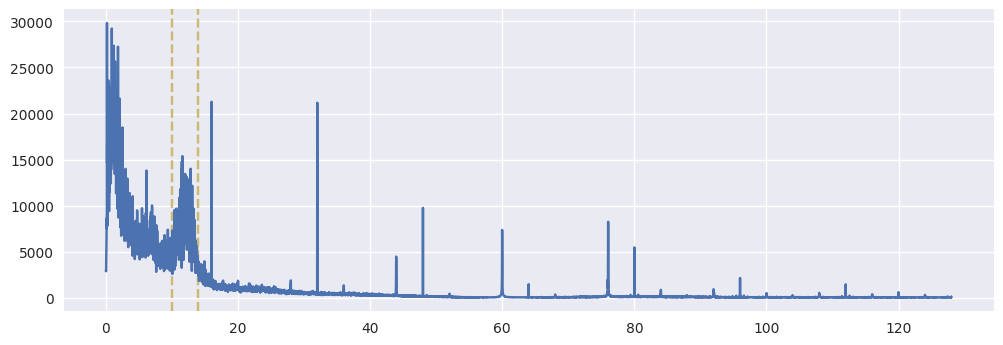

In [6]:
ffts = [abs(np.fft.fft(sg[sztimes[0]-window:sztimes[0]]))[:window//2] for sg in sig[0]]
ffts_mean = np.mean(ffts, axis=0)

freq = np.fft.fftfreq(window, d=1/256)[:window//2]
ind = np.where((freq>=10) & (freq<=14))[0]
plt.axvline(freq[ind[0]], color='C4', ls='--');
plt.axvline(freq[ind[-1]], color='C4', ls='--');
plt.plot(freq, ffts_mean);

In [7]:
df = pd.DataFrame()
for i in [0]:
    strain = pd.DataFrame([[int(abs(np.fft.fft(sg[j:j+window])[:window//2][ind[0]:ind[-1]]).mean()) for j in range(start[i],sztimes[i]-window,256)] for sg in sig[i]]).T

    strain['y'] = np.kaiser(len(strain)*2, 150)[:len(strain)]
    df = df.append(strain, ignore_index=True)

In [8]:
test = 1
stest = pd.DataFrame([[int(abs(np.fft.fft(sg[j:j+window])[:window//2][ind[0]:ind[-1]]).mean()) for j in range(start[test],sztimes[test]-window,256)] for sg in sig[test]]).T
    
x = df[df.columns[:-1]]
y = df[df.columns[-1]]

In [12]:
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,y
0,1683,1694,1973,2185,2291,2172,1902,2373,1943,1924,...,2031,2464,2622,2956,1973,1295,2346,1218,2031,2.200899e-64
1,1679,1692,1978,2179,2287,2169,1895,2377,1938,1938,...,2041,2464,2647,2941,1978,1272,2363,1218,2041,2.717504e-61
2,1674,1698,1972,2159,2304,2178,1871,2357,1946,1918,...,2020,2426,2624,2926,1972,1283,2387,1206,2020,9.923116e-60
3,1695,1715,1966,2185,2314,2205,1866,2377,1953,1923,...,2003,2437,2610,2936,1966,1296,2320,1199,2003,1.615114e-58
4,1680,1700,1984,2118,2320,2210,1890,2304,1953,1916,...,2013,2405,2597,2964,1984,1280,2274,1191,2013,1.714784e-57
5,1669,1664,1953,2101,2315,2212,1860,2305,1943,1892,...,1995,2370,2614,2937,1953,1267,2263,1198,1995,1.381125e-56
6,1668,1631,1937,2115,2315,2191,1877,2294,1954,1896,...,2014,2415,2605,2955,1937,1248,2251,1201,2014,9.127075e-56
7,1657,1620,1905,2123,2310,2186,1835,2316,1956,1891,...,2000,2445,2603,2898,1905,1237,2265,1189,2000,5.186953e-55
8,1637,1599,1955,2148,2256,2230,1848,2329,1962,1907,...,2009,2434,2634,2936,1955,1225,2242,1172,2009,2.614307e-54
9,1636,1587,1939,2160,2132,2155,1841,2341,1857,1877,...,2030,2428,2553,2878,1939,1226,2263,1165,2030,1.194005e-53


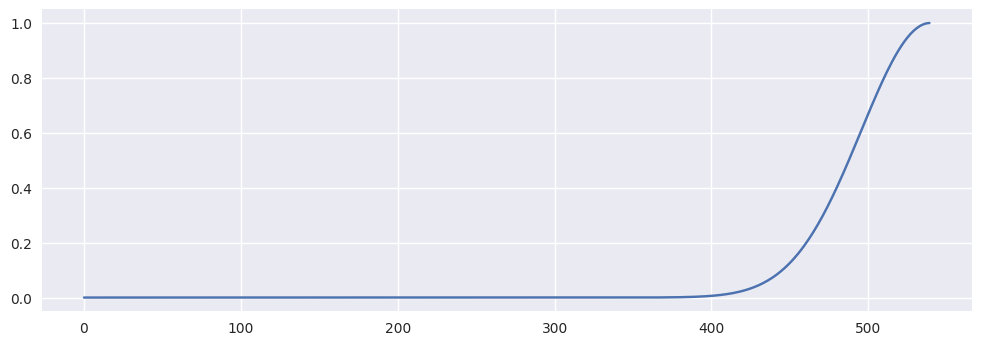

In [14]:
plt.plot(y);

In [9]:
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), KNeighborsRegressor()]
predictions = []
for model in models:
    tmp = model.fit(x,y)
    tmp = predictions.append(model.predict(stest))

In [10]:
@interact
def show_plot(i=(1, len(predictions), 1)):
    xx = np.arange(len(predictions[i-1]),0,-1)/60
    plt.plot(xx, predictions[i-1])
    plt.plot(xx, y[:predictions[i-1].size])
    plt.gca().invert_xaxis()
    plt.title(models[i-1].__class__.__name__)
# str(datetime.timedelta(seconds=int(540))) 

interactive(children=(IntSlider(value=2, description='i', max=4, min=1), Output()), _dom_classes=('widget-interact',))

### Test2 

In [11]:
result = pd.read_csv('pred_test2.csv').T
df2 = pd.read_csv('pred_test2_xy.csv')
y = df2.T.values[-1]
xx = np.arange(len(result[0]),0,-1)/60
probs = np.kaiser(len(xx)*2, 150)[:len(xx)]

In [20]:
df2

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,y
0,1683,1694,1973,2185,2291,2172,1902,2373,1943,1924,...,2031,2464,2622,2956,1973,1295,2346,1218,2031,2.200899e-64
1,1679,1692,1978,2179,2287,2169,1895,2377,1938,1938,...,2041,2464,2647,2941,1978,1272,2363,1218,2041,2.717504e-61
2,1674,1698,1972,2159,2304,2178,1871,2357,1946,1918,...,2020,2426,2624,2926,1972,1283,2387,1206,2020,9.923116e-60
3,1695,1715,1966,2185,2314,2205,1866,2377,1953,1923,...,2003,2437,2610,2936,1966,1296,2320,1199,2003,1.615114e-58
4,1680,1700,1984,2118,2320,2210,1890,2304,1953,1916,...,2013,2405,2597,2964,1984,1280,2274,1191,2013,1.714784e-57
5,1669,1664,1953,2101,2315,2212,1860,2305,1943,1892,...,1995,2370,2614,2937,1953,1267,2263,1198,1995,1.381125e-56
6,1668,1631,1937,2115,2315,2191,1877,2294,1954,1896,...,2014,2415,2605,2955,1937,1248,2251,1201,2014,9.127075e-56
7,1657,1620,1905,2123,2310,2186,1835,2316,1956,1891,...,2000,2445,2603,2898,1905,1237,2265,1189,2000,5.186953e-55
8,1637,1599,1955,2148,2256,2230,1848,2329,1962,1907,...,2009,2434,2634,2936,1955,1225,2242,1172,2009,2.614307e-54
9,1636,1587,1939,2160,2132,2155,1841,2341,1857,1877,...,2030,2428,2553,2878,1939,1226,2263,1165,2030,1.194005e-53


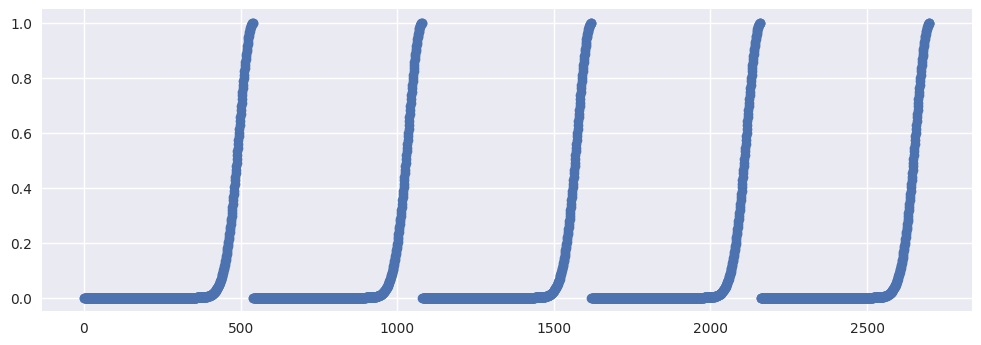

In [21]:
plt.plot(y, 'o');

In [19]:
@interact
def show_plot(i=(1, np.size(result, axis=1), 1)):
    plt.plot(xx, result[i-1])
    plt.plot(xx, y[:result[i-1].size])
    plt.gca().invert_xaxis()
    plt.title(models[i-1].__class__.__name__)
# str(datetime.timedelta(seconds=int(540))) 

interactive(children=(IntSlider(value=96, description='i', max=191, min=1), Output()), _dom_classes=('widget-interact',))

### Test 3 

###### random frequencies 

In [137]:
def select_random_windows(arr, window_size):
    offsets = np.random.randint(0, arr.shape[1]-window_size+1, size=arr.shape[0])
    return arr[np.arange(arr.shape[0])[:,None], offsets[:,None] + np.arange(window_size)]

rand_window = []
# for i in [1,2,3,4,5,6,8]:
for i in [10,20,30]:
    rand_window.append(select_random_windows(np.arange(120).reshape(i,120//i), 1))

ll = [print(str(rw[i])+'-'+str(rw[i+1])) for rw in rand_window for i in range(rw.size-1)]

[11]-[12]
[12]-[26]
[26]-[43]
[43]-[56]
[56]-[69]
[69]-[81]
[81]-[88]
[88]-[107]
[107]-[108]
[3]-[7]
[7]-[14]
[14]-[22]
[22]-[27]
[27]-[30]
[30]-[37]
[37]-[42]
[42]-[49]
[49]-[54]
[54]-[65]
[65]-[69]
[69]-[74]
[74]-[78]
[78]-[88]
[88]-[93]
[93]-[100]
[100]-[105]
[105]-[112]
[112]-[114]
[3]-[7]
[7]-[10]
[10]-[14]
[14]-[17]
[17]-[23]
[23]-[27]
[27]-[28]
[28]-[35]
[35]-[39]
[39]-[43]
[43]-[47]
[47]-[51]
[51]-[53]
[53]-[56]
[56]-[60]
[60]-[66]
[66]-[69]
[69]-[75]
[75]-[77]
[77]-[81]
[81]-[86]
[86]-[88]
[88]-[92]
[92]-[98]
[98]-[103]
[103]-[105]
[105]-[111]
[111]-[114]
[114]-[116]


###### high frequencies 

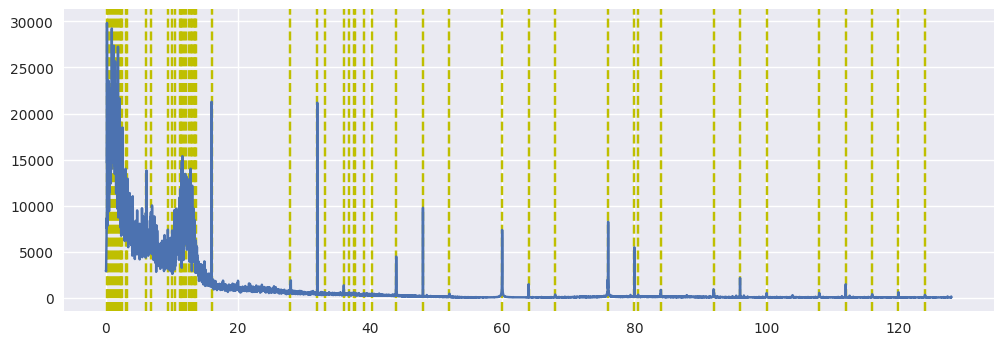

In [24]:
ffts = [abs(np.fft.fft(sg[sztimes[0]-window:sztimes[0]]))[:window//2] for sg in sig[0]]
ffts_mean = np.mean(ffts, axis=0)

freq = np.fft.fftfreq(window, d=1/256)[:window//2]
thres = (np.flipud(np.kaiser(len(ffts_mean)*2, 80)[:len(ffts_mean)]*ffts_mean.max()//9)).astype(np.int)
peaks = find_peaks(ffts_mean, height=0, distance=10, threshold=thres, prominence=250, wlen=None)[0]
tmp = [plt.axvline(freq[p], color='y', ls='--') for p in peaks]
plt.plot(freq, ffts_mean);

In [221]:
from os import path
mypath = './results_test1.2'
files = natsorted([f for f in listdir(mypath) if path.isfile(path.join(mypath, f))])

linear = pd.concat([pd.read_csv(path.join(mypath, f)) for f in files if 'Linear' in f], axis=1)
dtree = pd.concat([pd.read_csv(path.join(mypath, f)) for f in files if 'DecisionTree' in f], axis=1)
randomf = pd.concat([pd.read_csv(path.join(mypath, f)) for f in files if 'RandomForest' in f], axis=1)
kn = pd.concat([pd.read_csv(path.join(mypath, f)) for f in files if 'KNeighbors' in f], axis=1)

models = [linear, dtree, randomf, kn]

In [26]:
linear

,0.167,0.383,0.583,0.900,1.200,1.467,1.833,2.100,2.333,2.517,...,55-61,61-96,96-116,13-21,21-40,40-53,53-67,67-77,77-96,96-108
0,0.074761,0.104322,0.074765,0.216052,0.246267,0.060319,0.196550,0.070167,0.023458,0.171974,...,-0.452600,0.039518,-0.067693,-0.019252,0.091899,0.199971,-0.194803,-0.289051,-0.031846,-0.101051
1,0.065326,0.110344,0.049188,0.172012,0.226110,0.040441,0.223603,0.083526,0.015128,0.167800,...,-0.490219,0.046403,-0.050404,-0.035701,0.095805,0.212173,-0.224557,-0.317427,-0.016014,-0.068754
2,0.073059,0.101283,0.063948,0.173985,0.196045,0.031001,0.224638,0.061276,-0.001591,0.184625,...,-0.496070,0.043453,-0.078023,-0.100944,0.096781,0.183145,-0.218921,-0.295058,-0.028133,-0.098157
3,0.074194,0.117394,0.055848,0.167170,0.233231,0.021539,0.202094,0.071526,-0.006973,0.213113,...,-0.501735,0.026834,-0.074489,-0.073074,0.097758,0.193024,-0.245776,-0.301690,-0.041565,-0.107617
4,0.058822,0.144467,0.057077,0.153039,0.202827,0.031109,0.210168,0.034679,-0.027705,0.156814,...,-0.609356,-0.000105,-0.112328,-0.106704,0.101664,0.161856,-0.346146,-0.296915,-0.071411,-0.143232
5,0.039336,0.164635,0.064675,0.165694,0.183113,0.043262,0.216380,0.024760,-0.012562,0.126004,...,-0.481614,0.042551,-0.058577,-0.164688,0.103617,0.211056,-0.227116,-0.272817,-0.027759,-0.088906
6,-0.024361,0.200093,0.066461,0.176866,0.162548,0.063899,0.244319,-0.019779,-0.039743,0.110209,...,-0.437825,0.089496,-0.021777,-0.168187,0.147563,0.225897,-0.196996,-0.228262,0.001550,-0.065127
7,0.063997,0.155482,0.080053,0.154042,0.189578,0.133823,0.265995,0.069828,-0.012873,0.054651,...,-0.399654,0.061559,-0.016124,-0.209786,0.078227,0.204730,-0.169370,-0.227923,-0.019232,-0.055322
8,0.053562,0.190740,0.167392,0.130295,0.191942,0.121242,0.252094,0.009050,-0.001536,0.065801,...,-0.392702,0.022779,-0.035392,-0.212550,0.117289,0.180762,-0.168560,-0.262892,-0.029296,-0.063162
9,0.002948,0.132821,0.169889,0.157640,0.196836,0.131673,0.239374,-0.019886,0.029637,0.045995,...,-0.380264,0.057078,-0.061689,-0.216641,0.150981,0.216171,-0.162145,-0.223579,-0.006048,-0.094709


In [222]:
xx = np.arange(len(models[0]),0,-1)/60
probs = np.kaiser(len(xx)*2, 150)[:len(xx)]

filtered = []
for model in models:
    filtering = model.loc[:,(model.mean() > 0) & ((model < 1.5).all(axis=0)) & (model.std() >= 0.1) & (model[-50:].mean() <= 1) & (model[:400].std() <= 0.15) & (model[:400].mean() <= 0.4)]
    filtered.append(filtering.loc[:,~filtering.columns.duplicated()])

In [223]:
# [linear, dtree, randomf, kn]
best_len = 5
mR, mse_mins, mae_mins = [], [], []
for mod_n in range(len(models)):
    R = [round(np.corrcoef(filtered[mod_n][r], probs)[1,0], 14) for r in filtered[mod_n]]
    mR.append(heapq.nlargest(best_len, range(len(R)), key=R.__getitem__))

    mse = [mean_squared_error(filtered[mod_n][r], probs) for r in filtered[mod_n]]
    mae = [mean_absolute_error(filtered[mod_n][r], probs) for r in filtered[mod_n]]
    mse_mins.append(heapq.nsmallest(best_len, range(len(mse)), key=mse.__getitem__))
    mae_mins.append(heapq.nsmallest(best_len, range(len(mae)), key=mae.__getitem__))
    
best_unique = [list(OrderedDict.fromkeys(mR[i]+mse_mins[i]+mae_mins[i])) for i in range(len(models))]
result = [[filtered[i].iloc[:,r] for r in best_unique[i]]for i in range(len(filtered))]
# print(mR, mse_mins, mae_mins, sep='\n')

In [62]:
# best_freqs = [[111,113], [25,32], [43,46], [71,72], [72,77], [86,88], [97,102], [89,117], [81,84], [94,99], [80.5833]]

In [224]:
# [linear, dtree, randomf, kn]
mod_n = 3
@interact
def show_plot(i=(1, np.size(result[mod_n-1], axis=0), 1)):
#     xx = np.arange(len(result[0]),0,-1)/60
    plt.plot(xx, result[mod_n-1][i-1])
    plt.plot(xx, probs)
    plt.gca().invert_xaxis()
    plt.title(result[mod_n-1][i-1].name)

interactive(children=(IntSlider(value=4, description='i', max=7, min=1), Output()), _dom_classes=('widget-interact',))

means

In [225]:
mdl_names = ['LinearRegression', 'DecisionTree', 'RandomForest', 'KNeighbors']
@interact
def show_plot(i=(1, 4, 1)):
    mod_n = i
    maxes = best_unique[mod_n-1]
    mn = np.mean([result[mod_n-1][i-1] for i in range(1,np.size(result[mod_n-1], axis=0)+1)], axis=0)
    plt.plot(xx, mn)
    plt.plot(xx, probs)
    plt.gca().invert_xaxis()
    plt.title(mdl_names[mod_n-1])

interactive(children=(IntSlider(value=2, description='i', max=4, min=1), Output()), _dom_classes=('widget-interact',))